## **SATELLITE_GAN**

# ***CGAN***

The GAN architecture is comprised of a generator model for outputting new plausible synthetic images, and a discriminator model that classifies images as real (from the dataset) or fake (generated). The discriminator model is updated directly, whereas the generator model is updated via the discriminator model. As such, the two models are trained simultaneously in an adversarial process where the generator seeks to better fool the discriminator and the discriminator seeks to better identify the counterfeit images



cGAN, where the generation of the output image is conditional on an input, in this case, a source image. The discriminator is provided both with a source image and the target image and must determine whether the target is a plausible transformation of the source image.

The generator is trained via adversarial loss, which encourages the generator to generate plausible images in the target domain. The generator is also updated via L1 loss measured between the generated image and the expected output image. This additional loss encourages the generator model to create plausible translations of the source image.

## Satellite to Map Image Translation Dataset

maps dataset -This is a dataset comprised of satellite images of New York and their corresponding Google maps pages.Images have a digit filename and are in JPEG format. Each image is 1,200 pixels wide and 600 pixels tall and contains both the satellite image on the left and the Google maps image on the right.

The train folder contains 1,097 images, whereas the validation dataset contains 1,099 images.

# **Prepare the dataset for training**

Each image will be loaded, rescaled, and split into the satellite and Google map elements. The result will be 1,097 color image pairs with the width and height of 256×256 pixels.

The load_images() function below implements this. It enumerates the list of images in a given directory, loads each with the target size of 256×512 pixels, splits each image into satellite and map elements and returns an array of each.

In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed


In [ ]:
# load, split and scale the maps dataset ready for training
# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list() # create a list object

	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):

		# load and resize the image
		pixels = load_img(path + filename, target_size=size)

		# convert to numpy array
		pixels = img_to_array(pixels)

		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

## Load, split and scale the maps dataset ready for training

Running the example loads all images in the training dataset, summarizes their shape to ensure the images were loaded correctly, then saves the arrays to a new file called maps_256.npz in compressed NumPy array format

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset path
path = '/content/drive/MyDrive/Colab Notebooks/maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


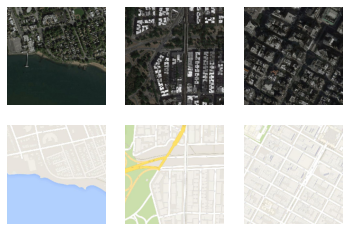

In [ ]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

# **Architecture**

The GAN architecture is comprised of a generator model for outputting new plausible synthetic images and a discriminator model that classifies images as real (from the dataset) or fake (generated). The discriminator model is updated directly, whereas the generator model is updated via the discriminator model. As such, the two models are trained simultaneously in an adversarial process where the generator seeks to better fool the discriminator and the discriminator seeks to better identify the counterfeit images

The architecture is comprised of two models: the discriminator and the generator

Generator:    
The encoder-decoder architecture consists of:
encoder:
C64-C128-C256-C512-C512-C512-C512-C512
decoder:
CD512-CD512-CD512-C512-C256-C128-C64


---




Discriminator
C64-C128-C256-C512
After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.  

In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model

### DISCRIMINATOR

The discriminator is a deep convolutional neural network that performs image classification. Specifically, conditional-image classification. It takes both the source image (e.g. satellite photo) and the target image (e.g. Google maps image) as input and predicts the likelihood of whether target image is real or a fake translation of the source image.

The discriminator design is based on the effective receptive field of the model, which defines the relationship between one output of the model to the number of pixels in the input image. This is called a PatchGAN model and is carefully designed so that each output prediction of the model maps to a 70×70 square or patch of the input image. The benefit of this approach is that the same model can be applied to input images of different sizes, e.g. larger or smaller than 256×256 pixels.

The output of the model depends on the size of the input image but may be one value or a square activation map of values. Each value is a probability for the likelihood that a patch in the input image is real. These values can be averaged to give an overall likelihood or classification score if needed.

 The discriminator model is updated directly, and the generator model is updated via the discriminator model, although the loss function is updated. The generator is trained via adversarial loss, which encourages the generator to generate plausible images in the target domain. The generator is also updated via L1 loss measured between the generated image and the expected output image. This additional loss encourages the generator model to create plausible translations of the source image.

In [ ]:
# example of calculating the receptive field for the PatchGAN

# calculate the effective receptive field size
def receptive_field(output_size, kernel_size, stride_size):
    return (output_size - 1) * stride_size + kernel_size

# output layer 1x1 pixel with 4x4 kernel and 1x1 stride
rf = receptive_field(1, 4, 1)
print(rf)
# second last layer with 4x4 kernel and 1x1 stride
rf = receptive_field(rf, 4, 1)
print(rf)
# 3 PatchGAN layers with 4x4 kernel and 2x2 stride
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)

4
7
16
34
70


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-yt5o1f65
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-yt5o1f65
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=a6e029dbec165d39edb83a5b712c7b63c1e93c38d66411c956e86eb705816e09
  Stored in directory: /tmp/pip-ephem-wheel-cache-qinmpvdp/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
# define the discriminator model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


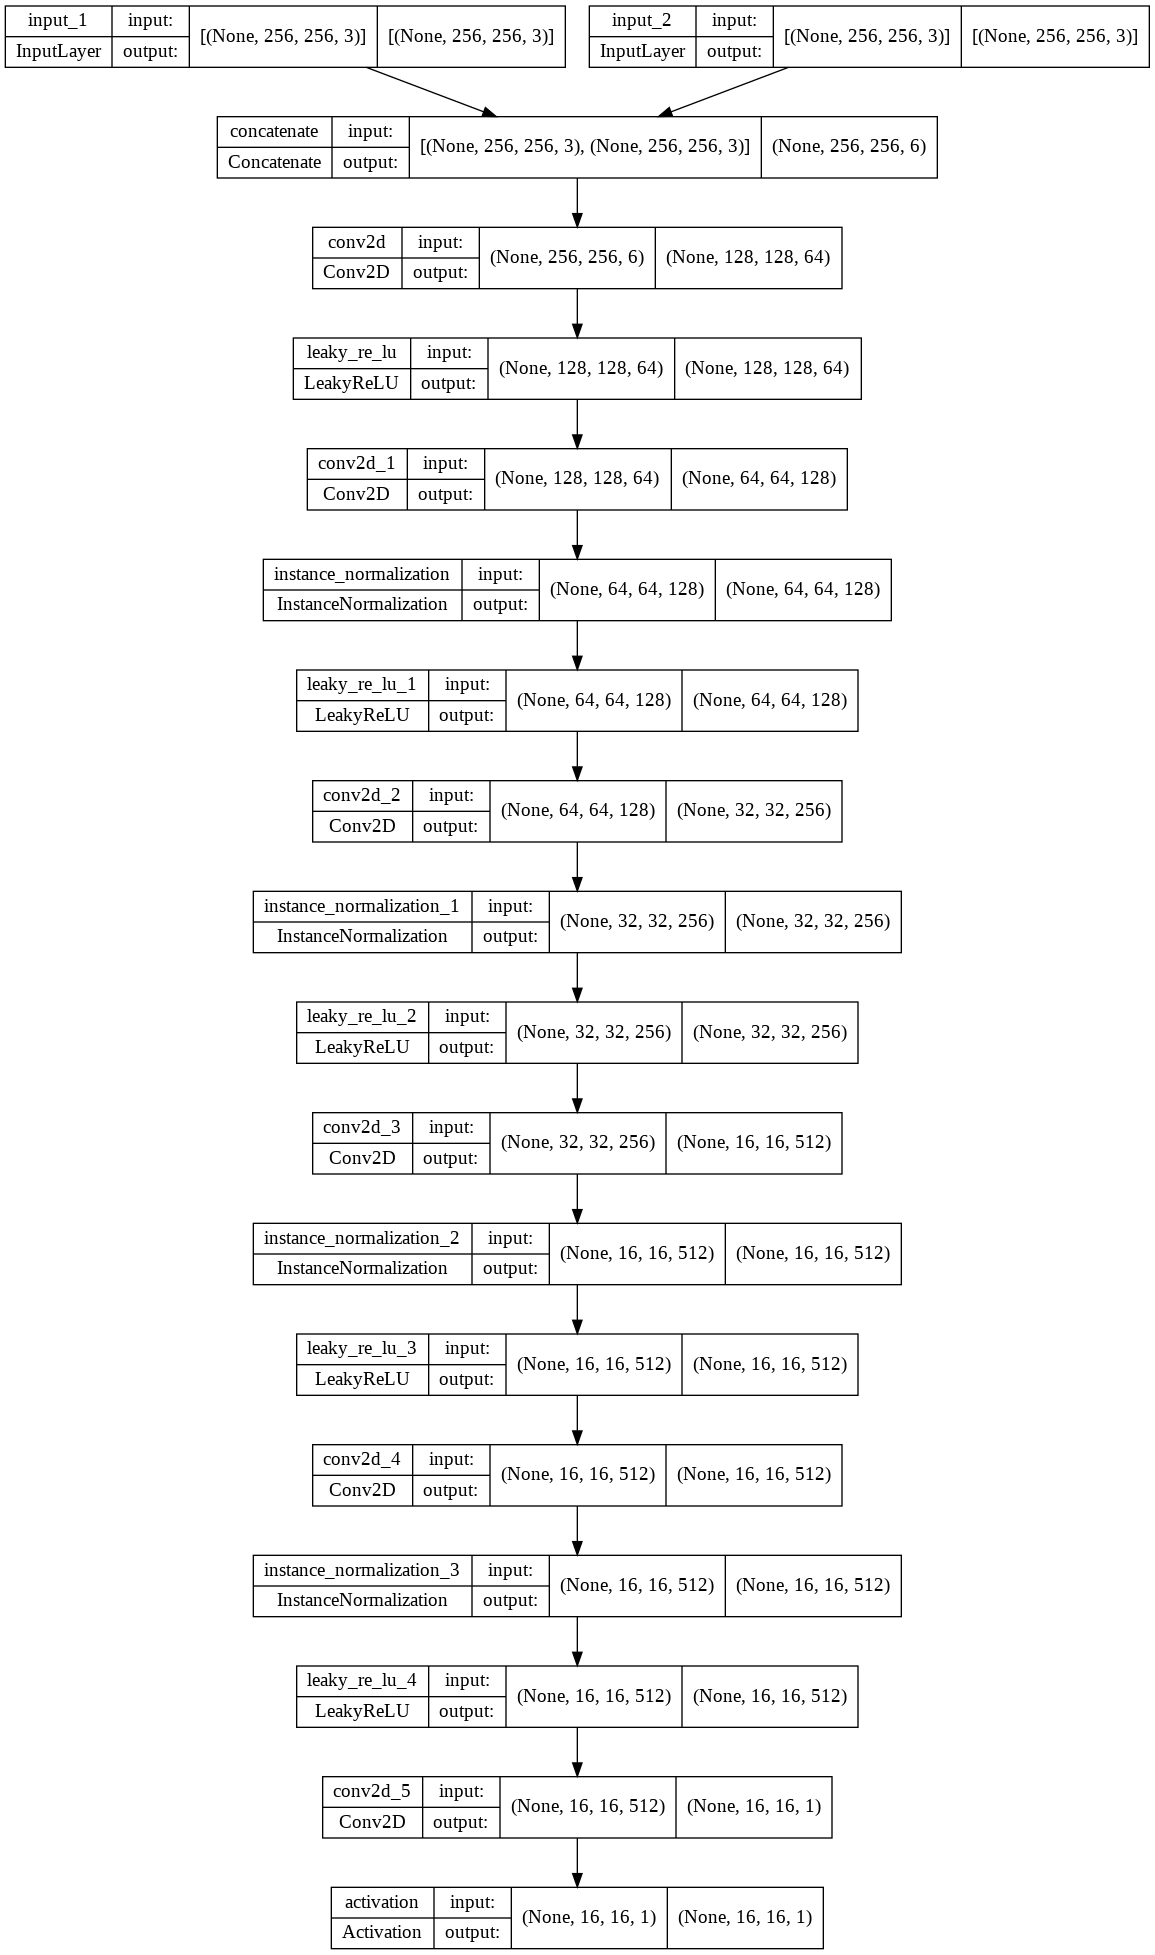

In [ ]:
# define image shape
image_shape = (256,256,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [ ]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [ ]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  3136        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_6[0][0]']               
                                )                                                           

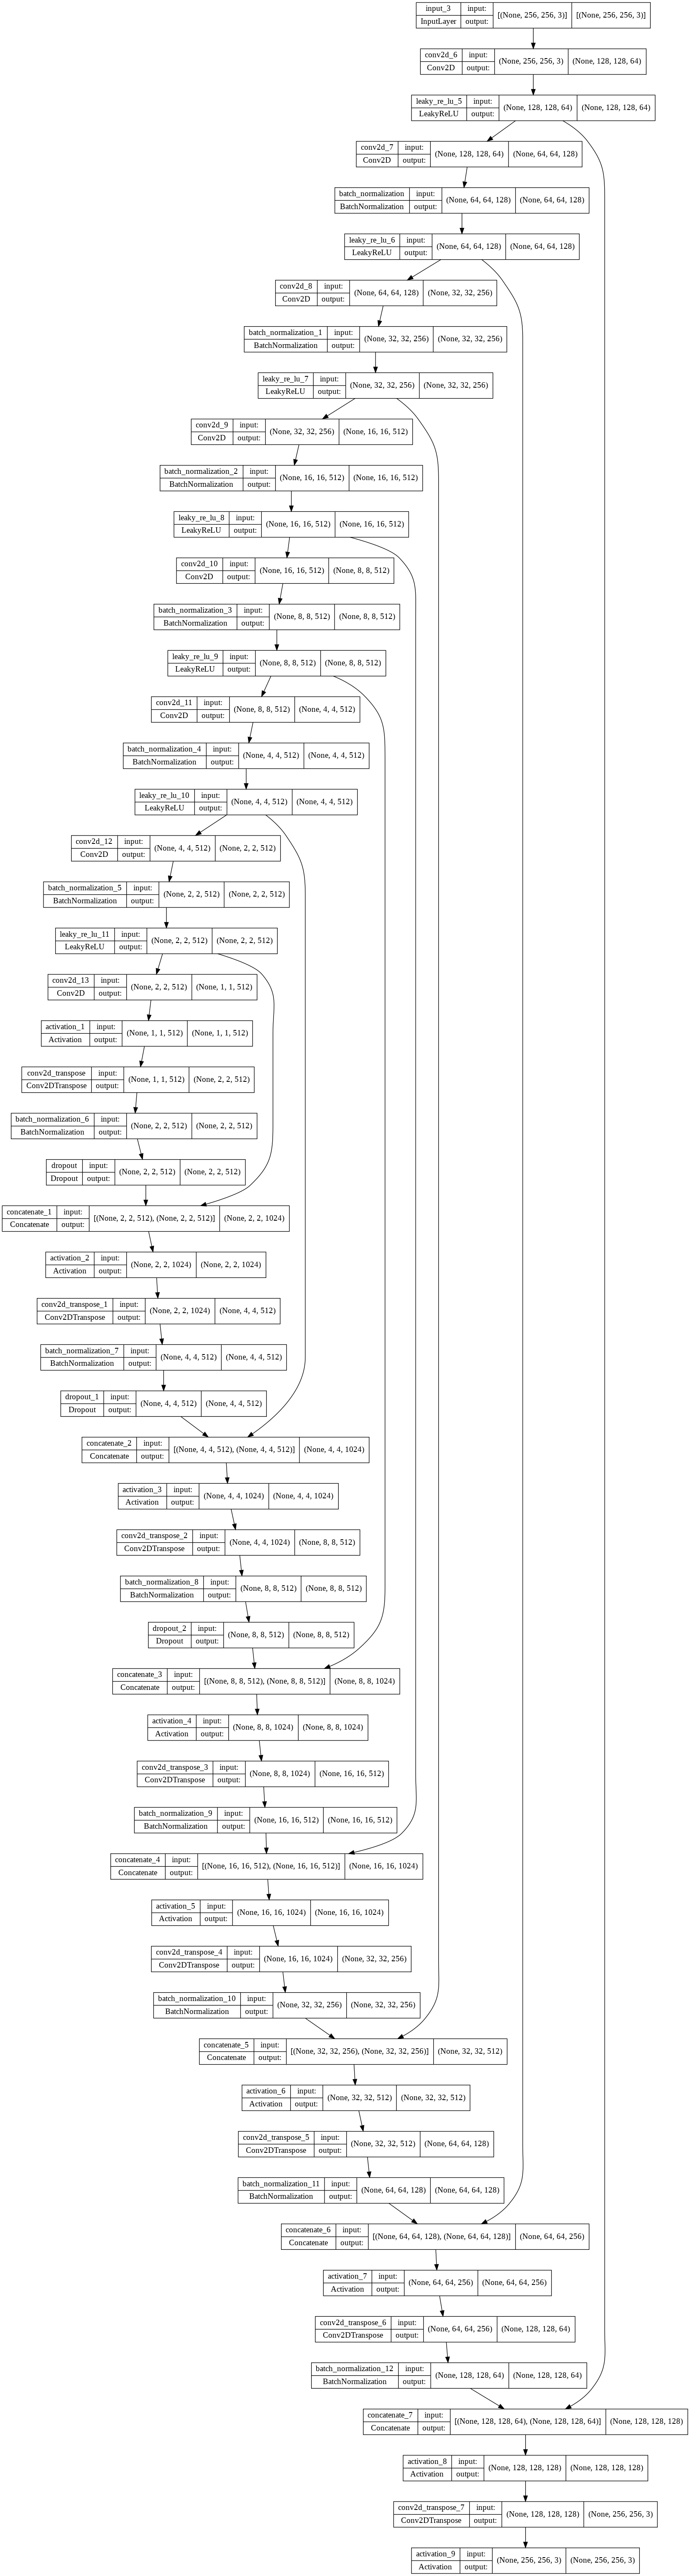

In [ ]:
# define image shape
image_shape = (256,256,3)
# create the model
model = define_generator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_3 (Functional)           (None, 256, 256, 3)  54429315    ['input_7[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 16, 16, 1)    6965441     ['input_7[0][0]',                
                                                                  'model_3[0][0]']                
                                                                                            

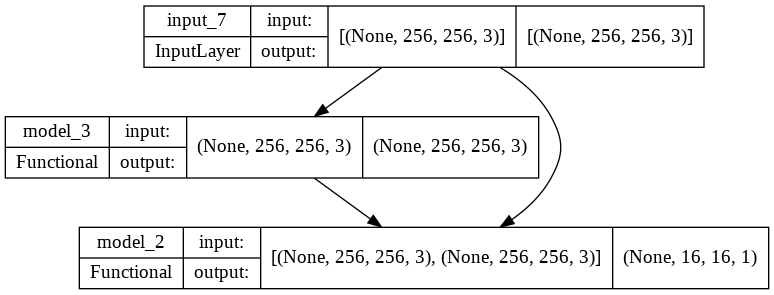

In [ ]:
# define image shape
image_shape = (256,256,3)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]


In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y


In [ ]:

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))




In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=40, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)


In [ ]:
# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
>38843, d1[0.039] d2[0.029] g[10.367]
>38844, d1[0.001] d2[0.065] g[14.398]
>38845, d1[0.001] d2[0.239] g[11.752]
>38846, d1[0.231] d2[0.027] g[9.412]
>38847, d1[0.138] d2[0.002] g[7.522]
>38848, d1[0.089] d2[0.011] g[10.315]
>38849, d1[0.018] d2[0.109] g[11.261]
>38850, d1[0.003] d2[0.002] g[10.682]
>38851, d1[0.035] d2[0.015] g[12.355]
>38852, d1[0.000] d2[0.010] g[11.388]
>38853, d1[0.129] d2[0.014] g[8.999]
>38854, d1[0.058] d2[0.004] g[10.084]
>38855, d1[0.009] d2[0.016] g[6.529]
>38856, d1[0.003] d2[0.059] g[7.710]
>38857, d1[0.009] d2[0.077] g[9.156]
>38858, d1[0.005] d2[0.031] g[8.882]
>38859, d1[0.071] d2[0.001] g[11.460]
>38860, d1[0.001] d2[0.205] g[13.314]
>38861, d1[0.057] d2[0.003] g[11.577]
>38862, d1[0.014] d2[0.003] g[15.076]
>38863, d1[0.003] d2[0.001] g[14.421]
>38864, d1[0.001] d2[0.669] g[15.096]
>38865, d1[0.015] d2[0.000] g[16.347]
>38866, d1[1.876] d2[0.009] g[9.681]
>38867, d1[0.030] d2[0.007] g[9.519]
>38868, 

### **TESTING**

In [ ]:
#from pix2pix_model import define_discriminator, define_generator, define_gan, train
# define input shape based on the loaded dataset
#image_shape = src_images.shape[1:]
# define the models
#d_model = define_discriminator(image_shape)
#g_model = define_generator(image_shape)
# define the composite model
#gan_model = define_gan(g_model, d_model, image_shape)

#Define data
# load and prepare training images
#data = [src_images, tar_images]

# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()


Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


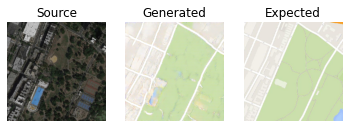

In [ ]:
import cv2
# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('model_043840.h5')
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)
#cv2.imwrite('generated1.jpg',gen_image)